<a href="https://colab.research.google.com/github/AP-047/RClass-Classification-by-Rational-Approximation/blob/main/notebooks/multi_dimensional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set Locale to UTF-8**

In [2]:
!apt-get install -y locales
!locale-gen en_US.UTF-8
!update-locale LANG=en_US.UTF-8

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
locales is already the newest version (2.35-0ubuntu3.8).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.


**Upgrade setuptools and pip**

In [1]:
!pip install -U setuptools pip

**Install CuPy for CUDA 12.2**

In [3]:
!pip install cupy-cuda12x

**4D**

len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
len(A[0]): 11
len(b): 15
Number of Iterations: 27
z Values in all Iterations: [50.0, 25.0, 12.5, 6.25, 3.125, 1.5625, 0.78125, 0.390625, 0.1953125, 0.09765625, 0.048828125, 0.0244140625, 0.01220703125, 0.006103515625, 0.0030517578125, 0.00152587890625, 0.000762939453125, 0.0003814697265625, 0.00019073486328125, 9.5367431640625e-05, 4.76837158203125

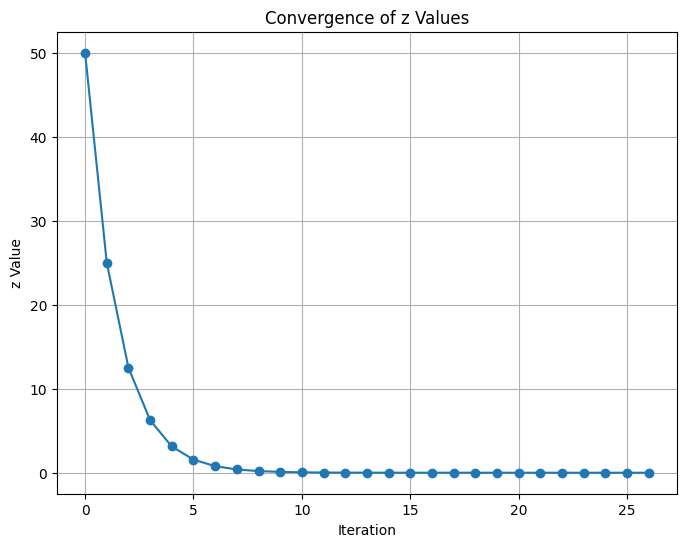

Optimized Coefficients (Numerator α): [4.64819183e-06 0.00000000e+00 1.17597673e-06 1.50486762e-08
 5.53071210e-10]
Optimized Coefficients (Denominator β): [8.48013346e-07 0.00000000e+00 3.79966635e-08 0.00000000e+00
 0.00000000e+00]
Optimal θ: 0.0


In [11]:
import cupy as cp
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Target function (explicit and simple definition)
def target_function(x):
    """
    Target function: |x1 + x2 + x3 + x4 - 0.1|.
    x is a vector of 4 variables for each data point.
    """
    return cp.abs(x[:, 0] + x[:, 1] + x[:, 2] + x[:, 3] - 0.1)


# Rational function (explicit definition for 4 variables)
def rational_function(x, alpha, beta):
    """
    Rational function:
    r(x) = (α_0 + α_1*x1 + α_2*x2 + α_3*x3 + α_4*x4) /
           (β_0 + β_1*x1 + β_2*x2 + β_3*x3 + β_4*x4).

    x is a vector of 4 variables for each data point.
    alpha and beta are the coefficients of the numerator and denominator.
    """
    # Numerator polynomial
    numerator = alpha[0] + alpha[1] * x[:, 0] + alpha[2] * x[:, 1] + alpha[3] * x[:, 2] + alpha[4] * x[:, 3]

    # Denominator polynomial
    denominator = beta[0] + beta[1] * x[:, 0] + beta[2] * x[:, 1] + beta[3] * x[:, 2] + beta[4] * x[:, 3]

    return numerator / denominator

delta = 1e-6  # A small positive value for the 3rd constraint

# Feasibility check function
def check_feasibility_and_compute_coefficients(z, x_data, y_data):
    num_data_points = x_data.shape[0]
    num_coefficients = 5  # 1 constant term + 4 variables

    # Construct G(x) and H(x) matrices for numerator and denominator
    G = cp.zeros((num_data_points, num_coefficients))  # Numerator matrix
    H = cp.zeros((num_data_points, num_coefficients))  # Denominator matrix

    for i in range(num_data_points):
        G[i, 0] = 1  # Constant term
        H[i, 0] = 1  # Constant term
        for j in range(0, num_coefficients):  # Variables with increasing powers
            G[i, j] = x_data[i, j - 1] ** j
            H[i, j] = x_data[i, j - 1] ** j

    # Construct constraints for Ax <= b
    A = []
    b = []

    for i in range(num_data_points):
        f_plus_z = y_data[i] + z  # Upper bound
        f_minus_z = y_data[i] - z  # Lower bound

        # Constraint 1: (f(xi) - z) * β^T H(xi) - α^T G(xi) ≤ θ
        constraint_1 = cp.zeros(2 * num_coefficients + 1)
        constraint_1[0:num_coefficients] = -G[i]  # Coefficients of α
        constraint_1[num_coefficients:2 * num_coefficients] = (f_minus_z) * H[i]  # Coefficients of β
        constraint_1[-1] = -1  # Coefficient of θ
        A.append(constraint_1)
        b.append(0)

        # Constraint 2: α^T G(xi) - (f(xi) + z) * β^T H(xi) ≤ θ
        constraint_2 = cp.zeros(2 * num_coefficients + 1)
        constraint_2[0:num_coefficients] = G[i]  # Coefficients of α
        constraint_2[num_coefficients:2 * num_coefficients] = -(f_plus_z) * H[i]  # Coefficients of β
        constraint_2[-1] = -1  # Coefficient of θ
        A.append(constraint_2)
        b.append(0)

        # Constraint 3: β^T H(x) ≥ δ
        constraint_3 = cp.zeros(2 * num_coefficients + 1)
        constraint_3[num_coefficients:2 * num_coefficients] = -H[i]  # Coefficients of β
        A.append(constraint_3)
        b.append(-delta)

    # Convert CuPy arrays to NumPy arrays for SciPy
    A = cp.asnumpy(cp.array(A))
    b = cp.asnumpy(cp.array(b))

    # print(f"A =", len(A))
    # print(f"A: {A[0]}")
    print(f"len(A[0]): {len(A[0])}")
    print(f"len(b): {len(b)}")

    # Objective function to minimize θ
    c = cp.asnumpy(cp.zeros(2 * num_coefficients + 1))
    c[-1] = 1  # Only θ has a coefficient in the objective function

    # Solve the linear programming problem
    result = linprog(c, A_ub=A, b_ub=b, method="highs")

    # Check feasibility and return results
    if result.success:
        alpha_coefficients = result.x[:num_coefficients]
        beta_coefficients = result.x[num_coefficients:2 * num_coefficients]
        theta = result.x[-1]
        return True, alpha_coefficients, beta_coefficients, theta
    else:
        return False, None, None, None


# Bisection loop
def bisection_loop(x_data, y_data, uL, uH, precision):
    optimal_alpha, optimal_beta, optimal_theta = None, None, None
    z_values = []

    while uH - uL > precision:
        z = (uL + uH) / 2
        z_values.append(z)
        feasible, alpha_coefficients, beta_coefficients, theta = check_feasibility_and_compute_coefficients(z, x_data, y_data)

        if feasible:
            uH = z
            optimal_alpha, optimal_beta, optimal_theta = alpha_coefficients, beta_coefficients, theta
        else:
            uL = z

    return uH, optimal_alpha, optimal_beta, optimal_theta, z_values

# Main execution
if __name__ == "__main__":
    # Data setup
    x_data = cp.array([[1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [2, 4, 5, 9], [3, 4, 8, 9]])
    y_data = target_function(x_data)

    # Bisection parameters
    uL = 0  # Initial lower bound
    uH = 100  # Initial upper bound
    precision = 1e-6  # Precision threshold

    # Run bisection loop
    optimal_z, optimal_alpha, optimal_beta, optimal_theta, z_values = bisection_loop(x_data, y_data, uL, uH, precision)

    # Print results
    print(f"Number of Iterations: {len(z_values)}")
    print(f"z Values in all Iterations: {z_values}")
    print(f"Optimal z (Maximum Deviation): {optimal_z}")

    # Plot convergence of z values
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(z_values)), z_values, marker='o', linestyle='-')
    plt.xlabel("Iteration")
    plt.ylabel("z Value")
    plt.title("Convergence of z Values")
    plt.grid(True)
    plt.show()

    print(f"Optimized Coefficients (Numerator α): {optimal_alpha}")
    print(f"Optimized Coefficients (Denominator β): {optimal_beta}")
    print(f"Optimal θ: {optimal_theta}")